In [1]:
!pip install numpy

import numpy as np

rng = np.random.default_rng(0)

In [11]:
''' Возьмем простые данные - n-мерное изотропное нормальное распределение N(0, I_d) '''

def logp(x):
    return -0.5 * np.dot(x, x)

def grad_logp(x):
    return -x

def your_data_utils(x):
    ''' Здесь придумайте какой-нибудь свой пример с данными по аналогии с гауссинками и проверьте алгоритмы на них '''
    def logp_corr(x, rho=0.9):
        d = len(x)
        a = 1 / (1 - rho)
        b = -rho / ((1 - rho) * (1 - rho + rho * d))
        quad = a * np.dot(x, x) + b * (np.sum(x) ** 2)
        return -0.5 * quad

    def grad_logp_corr(x, rho=0.9):
        d = len(x)
        a = 1 / (1 - rho)
        b = -rho / ((1 - rho) * (1 - rho + rho * d))
        s = np.sum(x)
        return -(a * x + b * s * np.ones_like(x))

    return logp_corr, grad_logp_corr


In [4]:
''' Посчитаем ESS через интегрированную автокорреляции '''

def ess(x):
    x = x - x.mean()

    acf = np.correlate(x, x, mode='full')
    acf = acf[len(acf) // 2:]
    acf /= acf[0]

    tau = 1 + 2 * np.sum(acf[1:200])

    return len(x) / tau

In [5]:
''' Базовая реализация MH алгоритма '''

def mh(x0, steps, scale):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        prop = x + rng.normal(0, scale, size=d)

        if np.log(rng.uniform()) < (logp(prop) - logp(x)):
            x = prop; accept += 1

        chain[t] = x

    return chain, accept / steps

In [6]:
# Тут нужно заимплементить Metropolis Adjusted Langevin Algorithm (MALA)

def mala(x0, steps, step):
    x = x0.copy()
    d = len(x)
    chain = np.zeros((steps, d))
    accept = 0
    h = step ** 2

    for t in range(steps):
        g = grad_logp(x)
        mean_prop = x + 0.5 * h * g
        y = mean_prop + step * rng.normal(size=d)

        gy = grad_logp(y)
        mean_back = y + 0.5 * h * gy

        def log_q(z, m):
            return -0.5 * np.dot(z - m, z - m) / h

        log_alpha = (logp(y) - logp(x)) + (log_q(x, mean_back) - log_q(y, mean_prop))

        if np.log(rng.uniform()) < log_alpha:
            x = y
            accept += 1

        chain[t] = x

    return chain, accept / steps

In [7]:
d = 10
steps = 30000
burn = 5000
x0 = np.ones(d) * 3 # стартанев в точке 3 например

mala_step = 0.6 # тут попробуйте подобрать хороший шаг
mh_scale = 0.8 # тут попробуйте подобрать скейл для пропозала в MH. Может какие-то варианты будут лучше MALA?

mh_chain, mh_acc = mh(x0, steps, scale=mh_scale)
mala_chain, mala_acc = mala(x0, steps, step=mala_step)

# Выведите снизу acceptance rate и медианный ESS по размерности d для MH и MALA. Не забудьте обрезать burn-in!
mh_post = mh_chain[burn:]
mala_post = mala_chain[burn:]

def median_ess(chain):
    return np.median([ess(chain[:, j]) for j in range(chain.shape[1])])

print(f"MH accept: {mh_acc:.3f} | median ESS: {median_ess(mh_post):.1f}")
print(f"MALA accept: {mala_acc:.3f} | median ESS: {median_ess(mala_post):.1f}")

MH accept: 0.236 | median ESS: 850.6
MALA accept: 0.929 | median ESS: 2411.7


In [12]:
logp, grad_logp = your_data_utils(None)

mh_chain2, mh_acc2 = mh(x0, steps, scale=mh_scale)
mala_chain2, mala_acc2 = mala(x0, steps, step=mala_step)

mh_post2 = mh_chain2[burn:]
mala_post2 = mala_chain2[burn:]

print(f"MH corr accept: {mh_acc2:.3f} | median ESS: {median_ess(mh_post2):.1f}")
print(f"MALA corr accept: {mala_acc2:.3f} | median ESS: {median_ess(mala_post2):.1f}")


MH corr accept: 0.004 | median ESS: 64.2
MALA corr accept: 0.029 | median ESS: 72.2


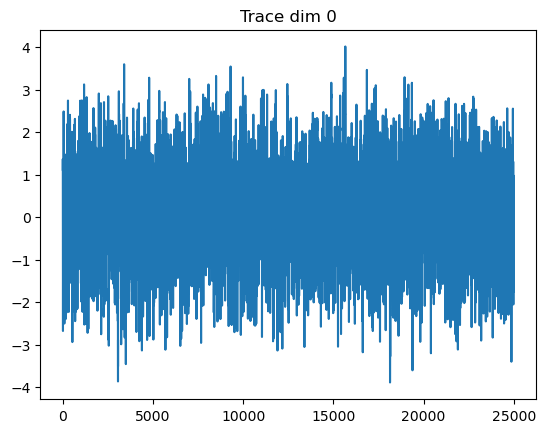

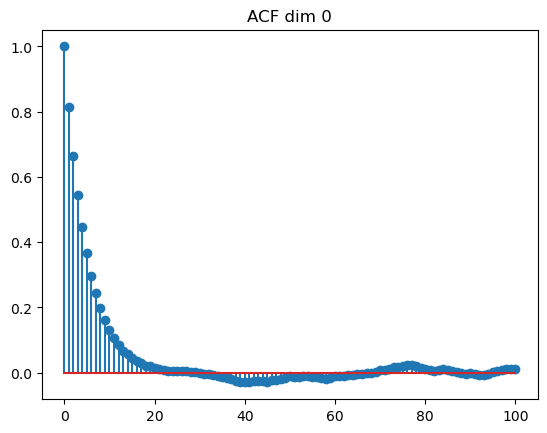

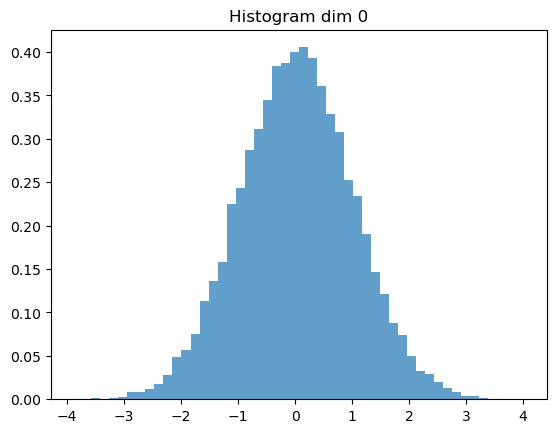

In [10]:
# Здесь нарисуйте 3 графика: trace plot (значение цепи vs итерация),
# график автокорреляции (значение ACF vs задержка по времени) и гистограмма семплов (возьмите какую-то одну размерность)

import matplotlib.pyplot as plt

i = 0

def acf_vals(x, max_lag=100):
    x = x - x.mean()
    n = len(x)
    c = np.correlate(x, x, mode='full')[n-1:] / np.arange(n, 0, -1)
    c = c / c[0]
    return c[:max_lag+1]

series = mala_post[:, i]

plt.figure()
plt.plot(series)
plt.title(f"Trace dim {i}")
plt.show()

plt.figure()
lags = acf_vals(series, 100)
plt.stem(range(len(lags)), lags)
plt.title(f"ACF dim {i}")
plt.show()

plt.figure()
plt.hist(series, bins=50, density=True, alpha=0.7)
plt.title(f"Histogram dim {i}")
plt.show()


In [ ]:
На простых данных MALA работал заметно быстрее и эффективнее, чем MH, цепь лучше перемешивается и дает больше независимых сэмплов.
На коррелированных данных оба метода замедляются. Однако MALA все равно показывает немного лучшие результаты.